In [1]:
import contextily as cx
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd

plt.style.use("ggplot")

# Catchment delineation for locations in Norway

This notebook illustrates how to use NivaPy to delineate watershed boundaries for outflow locations in Norway.

## 1. Example data

As a starting point, the user must supply a dataframe listing locations for catchment outflows of interest. The dataframe must include columns for the x and y co-ordinates, plus a column with a unique identifier for each location (in other words, each row of the dataframe should have a unique identifier).

Data can be provided in any co-ordinate system you wish, but if the co-ordinates are not WGS84-based lat/lon (the default), you **must remember to explicitly specify the CRS**. The API requires co-ordinates in UTM Zone 33N, so whatever data you provide will first be reprojected to this CRS before submitting the query. This is handled automatically, *as long as you specify the original CRS correctly* (see below).

**Note:** The catchment delineation function uses an elevation model that includes the [ELVIS stream](https://kartkatalog.geonorge.no/metadata/elvis-elvenett/3f95a194-0968-4457-a500-912958de3d39) network. For best results, **make sure your outflow points are located precisely on an ELVIS stream segment**. [NVE Atlas](https://atlas.nve.no/Html5Viewer/index.html?viewer=nveatlas#) can be helpful for this: first turn on the ELVIS streams layer (`Vassdrag > Elvenett > Elvenett`) and then zoom in closely on your points of interest (the streams layer only becomes visible at higher zoom levels). Right-click any point on the stream network to display WGS84-based latitude and longitude co-ordinates (`epsg:4326`).

In [2]:
# Read example data from Finnmark
csv_path = "../../example_data/quantom_catchment_outlets.csv"
df = pd.read_csv(csv_path, sep=";")
df.head()

,site_id,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,Njahkajavri,68.879606,23.761291,480
1,2,Vuomajeaggi,69.016558,24.142340,365
2,3,Juovvajohka,69.091233,24.473330,311
3,4,Caskin-jeaggi / Caskinjohka,68.926158,25.597493,211
4,6,Fáhttevárleakšá,69.594406,25.012381,350


## 2. Derive watersheds

See the docstring for full details of how to use `derive_watershed_boundaries()`.

In [3]:
nivapy.spatial.derive_watershed_boundaries?

Signature:
nivapy.spatial.derive_watershed_boundaries(
    df,
    id_col='station_code',
    xcol='longitude',
    ycol='latitude',
    crs='epsg:4326',
    min_size_km2=None,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=True,
)
Docstring:
Calculate watershed boundaries in Norway based on outflow co-ordinates provided
as a dataframe.

Args
    df:           Dataframe. Containing co-ordinates for catchment outflow points
    id_col:       Str. Name of column in 'df' containing a unique ID for each
                  outflow point. This will be used to link derived catchments
                  to the original points. Must be unique
    xcol:         Str. Name of column in 'df' containing 'eastings' (i.e. x or
                  longitude)
    ycol:         Str. Name of column in 'df' containing 'northings' (i.e. y or
                  latitude)
    crs:          Str. A valid co-ordinate reference system for Geopandas. Most
                  easily expressed usin

### 2.1. Using the 40 m DTM

A good starting point is to use the 40 m DTM. This will be good enough for many applications, and it's fast and not too memory-intensive. It is recommended to try this first and then move to higher resolutions if necessary.

**Note:** The first time you run this function in each JupyterHub session, NivaPy imports and compiles some Cython code via [PySheds](https://github.com/mdbartos/pysheds). **This can take a minute or so**. After that, the function should run more quickly for the rest of your session.

In [4]:
gdf40 = nivapy.spatial.derive_watershed_boundaries(
    df,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
    min_size_km2=2,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
gdf40.head()

Connection successful.


Looping over vassdragsområder:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 212:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/20 [00:00<?, ?it/s]

,site_id,geometry,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,"POLYGON ((850760.000 7669280.000, 850840.000 7...",Njahkajavri,68.879606,23.761291,480
1,10,"POLYGON ((968240.000 7837520.000, 968440.000 7...",Jeakkášjávri,70.127020,27.685320,102
2,10b,"POLYGON ((983440.000 7859160.000, 983600.000 7...",Golggotjohka,70.294060,28.083093,0
3,11,"POLYGON ((879400.000 7674840.000, 879600.000 7...",?uovžajohka,68.869618,24.601541,390
4,12,"POLYGON ((895600.000 7724880.000, 896000.000 7...",Šuolggajohka,69.338290,25.098504,156


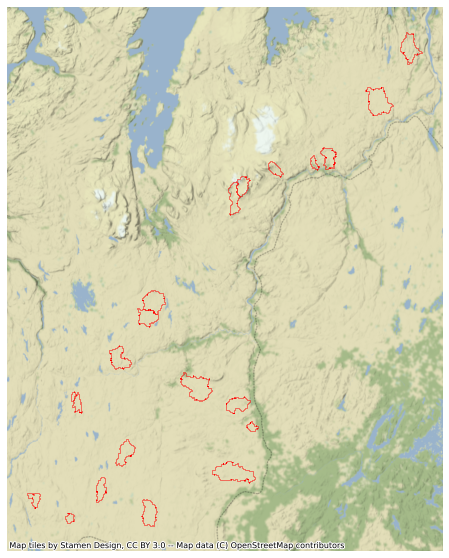

In [5]:
# Plot
ax = gdf40.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=gdf40.crs, source=cx.providers.Stamen.Terrain)
ax.set_axis_off()

### 2.2. With clipping

The code above first identifies which vassdragsområder the outlet points are located in and then processes each vassdragsområde in turn. This generally works well, but the elevation datasets for some vassdragsområder are large. If you are delineating small catchments spread across many vassdragsområder, you can reduce memory consumption and improve performance by using the `buffer_km` parameter (see the function `docstring` above for an explanation of how this parameter works). 

If you provide a value for `buffer_km`, you must also set the `temp_fold` parameter (which must be a location on the `shared` drive because data volumes may be large). It is recommended to create a folder on `shared` with your initials and then use a subfolder there. The folder you specify will be used to store temporary files during the calculation (which will be deleted when the function completes).

The code below produces identical output to that above, but in about 15 seconds rather than 40. Peak memory consumption is also lower, as with `buffer_km=20` the function never reads more than a 40 by 40 km square of data into memory at any given time (compared to an entire vassdragområde in the first example). In this case, the performance gain is probably not worth it - especially if you have no idea *a priori* how big or small your catchments will be. However, in cases where you know you're delineating large numbers of small catchments spread across many vassdragsområder, the difference in processing time can be significant.

**Note:** Whenever you set `buffer_km`, it is important to check the output carefully. In particular, **watch out for catchment boundaries that seem suspiciously linear in the east-west or north-south directions**. This is often an indication that you have set the `buffer_km` value too small and your catchments are being artificially truncated. The effect is not always as obvious as you might expect, so if in doubt make `buffer_km` large, or set it to `None` and use a more powerful machine. If possible, it's also a good idea to sense-check your boundaries by comparing them to e.g. the Elvis river network using desktop GIS.

In [6]:
temp_fold = r"/home/jovyan/shared/01_datasets/spatial/temp/cat_delin_temp"

gdf40 = nivapy.spatial.derive_watershed_boundaries(
    df,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
    min_size_km2=2,
    dem_res_m=40,
    buffer_km=20,
    temp_fold=temp_fold,
    reproject=False,
)
gdf40.head()

Connection successful.


Looping over vassdragsområder:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 212:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/20 [00:00<?, ?it/s]

,site_id,geometry,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,"POLYGON ((850760.000 7669280.000, 850840.000 7...",Njahkajavri,68.879606,23.761291,480
1,10,"POLYGON ((968240.000 7837520.000, 968440.000 7...",Jeakkášjávri,70.127020,27.685320,102
2,10b,"POLYGON ((983440.000 7859160.000, 983600.000 7...",Golggotjohka,70.294060,28.083093,0
3,11,"POLYGON ((879400.000 7674840.000, 879600.000 7...",?uovžajohka,68.869618,24.601541,390
4,12,"POLYGON ((895600.000 7724880.000, 896000.000 7...",Šuolggajohka,69.338290,25.098504,156


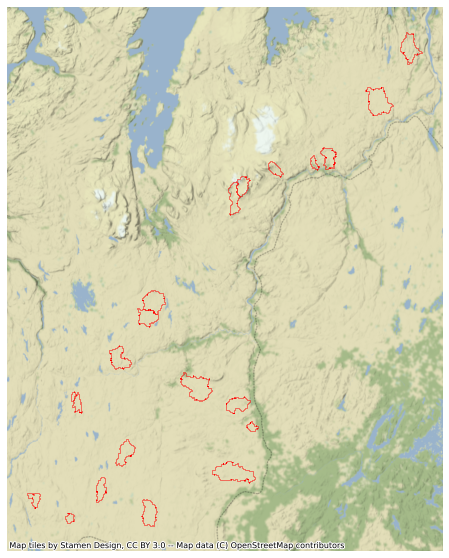

In [7]:
# Plot
ax = gdf40.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=gdf40.crs, source=cx.providers.Stamen.Terrain)
ax.set_axis_off()

### 2.3. Using the 10 m or 20 m DTMs

For other resolutions, the interface is exactly the same as above - just set `dem_res_m` to either `10` or `20`.

**Note:** For working with the 10 or 20 m datasets, it is recommended to **sign in on a machine with plenty of memory (e.g. 48 or 60 GB)**. If you try delineating catchments at high resolution on a `standard` (i.e. shared) machine with only 12 GB of RAM, it is likely your server will be "kicked off"/shut down to avoid your code consuming resources needed by other users. The example here uses `buffer_km=20` to keep memory consumption low.

**Tip:** You can monitor the resources used by your code by opening a terminal and running the `top` command. This will start a simple process monitor (a bit like the Task Manager in Windows) where you can see how much CPU and memory each process is consuming.

In [8]:
gdf20 = nivapy.spatial.derive_watershed_boundaries(
    df,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
    min_size_km2=2,
    dem_res_m=20,
    buffer_km=20,
    temp_fold=temp_fold,
    reproject=False,
)
gdf20.head()

Connection successful.


Looping over vassdragsområder:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 212:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/20 [00:00<?, ?it/s]

,site_id,geometry,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,"POLYGON ((850760.000 7669300.000, 850840.000 7...",Njahkajavri,68.879606,23.761291,480
1,10,"POLYGON ((968260.000 7837520.000, 968400.000 7...",Jeakkášjávri,70.127020,27.685320,102
2,10b,"MULTIPOLYGON (((987620.000 7850000.000, 987620...",Golggotjohka,70.294060,28.083093,0
3,11,"POLYGON ((879400.000 7674840.000, 879600.000 7...",?uovžajohka,68.869618,24.601541,390
4,12,"POLYGON ((895840.000 7724900.000, 895960.000 7...",Šuolggajohka,69.338290,25.098504,156


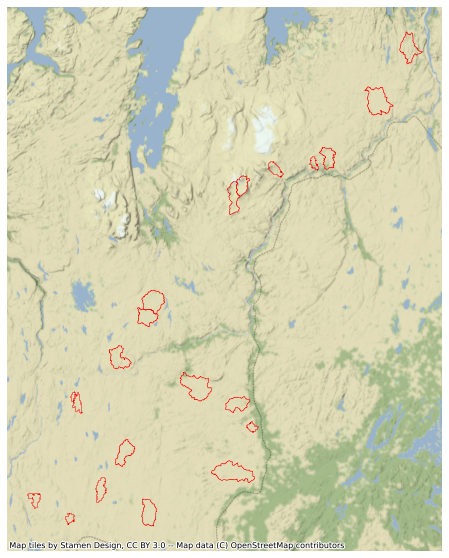

In [9]:
# Plot
ax = gdf20.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=gdf20.crs, source=cx.providers.Stamen.Terrain)
ax.set_axis_off()

### 2.4. Compare 20 m and 40 m results with output from Nevina

[Nevina](https://nevina.nve.no/) is an NVE website where you can delineate catchment boundaries. If you only need boundaries for a few catchments, Nevina is great - especially because it offers additional summary information for the catchments you derive. For greater numbers of catchments, however, Nevina can be very slow. The code below compares results obtained manually from Nevina with those from the 20 m and 40 m datasets used by NivaPy.

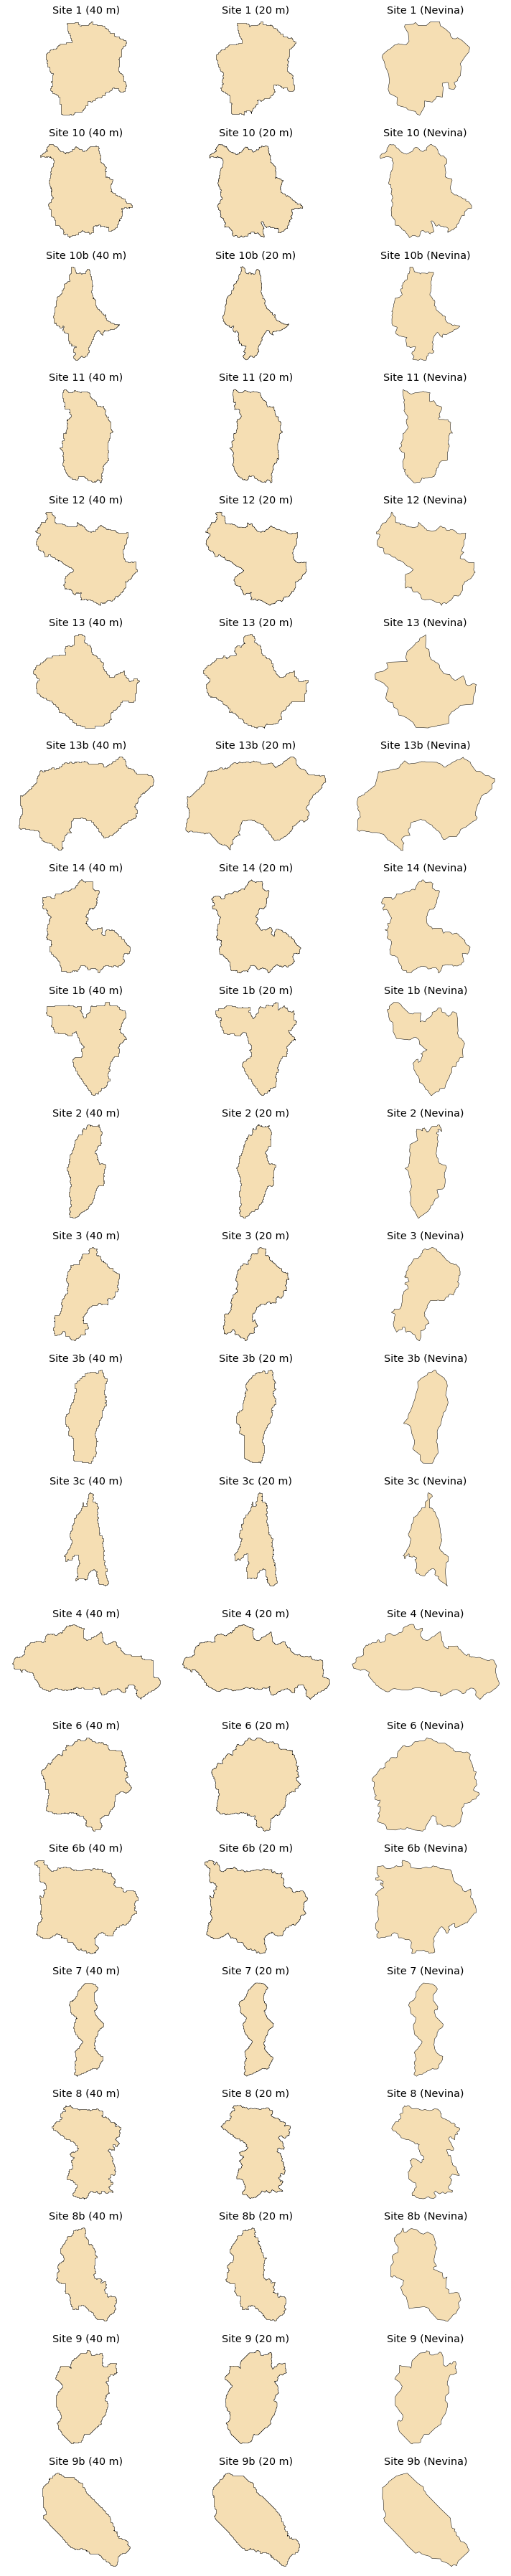

In [10]:
# Read Nevina shapefile
nev_gdf = gpd.read_file("../../example_data/catchment_boundaries_2021.shp")

# Plot each catchment side-by-side
fig, axes = plt.subplots(ncols=3, nrows=len(gdf40), figsize=(10, 50))
for idx, site_id in enumerate(gdf40["site_id"].unique()):
    gdf40.query("site_id == @site_id").plot(
        ax=axes[idx, 0], edgecolor="k", facecolor="wheat"
    )
    gdf20.query("site_id == @site_id").plot(
        ax=axes[idx, 1], edgecolor="k", facecolor="wheat"
    )
    nev_gdf.query("site_id == @site_id").plot(
        ax=axes[idx, 2], edgecolor="k", facecolor="wheat"
    )
    axes[idx, 0].set_title(f"Site {site_id} (40 m)")
    axes[idx, 1].set_title(f"Site {site_id} (20 m)")
    axes[idx, 2].set_title(f"Site {site_id} (Nevina)")
    axes[idx, 0].set_axis_off()
    axes[idx, 1].set_axis_off()
    axes[idx, 2].set_axis_off()

plt.tight_layout()